In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [5]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}


# Stochastic Gradient Descent

In [79]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [80]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgd)

<module 'hamiltonian.inference.sgd' from '../hamiltonian/inference/sgd.py'>

In [81]:
par,loss=inference.fit_gluon(epochs=10,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


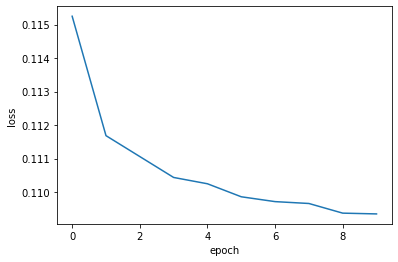

In [82]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [83]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [84]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [85]:
samples=np.asarray(samples)

In [86]:
samples.shape

(100, 14000)

In [87]:
y_hat=np.quantile(samples,.5,axis=0)

In [88]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1401
           1       0.95      0.97      0.96      1551
           2       0.95      0.84      0.89      1355
           3       0.91      0.89      0.90      1457
           4       0.82      0.96      0.88      1347
           5       0.95      0.70      0.81      1296
           6       0.91      0.95      0.93      1336
           7       0.93      0.92      0.92      1449
           8       0.74      0.90      0.81      1388
           9       0.91      0.85      0.88      1420

    accuracy                           0.90     14000
   macro avg       0.90      0.89      0.89     14000
weighted avg       0.90      0.90      0.90     14000



In [77]:
X_batch=nd.array(X_train[:32],ctx=model_ctx)
y_batch=nd.array(y_train[:32],ctx=model_ctx)

In [78]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

# Stochastic Gradient Langevin Dynamics

In [44]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par,step_size=0.05,ctx=model_ctx)

In [45]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [46]:
par,loss=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


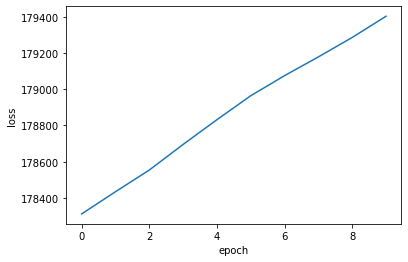

In [48]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [42]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [29]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1385
           1       0.01      0.00      0.00      1602
           2       0.06      0.04      0.05      1428
           3       0.05      0.02      0.03      1421
           4       0.11      0.01      0.02      1357
           5       0.08      0.22      0.12      1252
           6       0.11      0.26      0.16      1381
           7       0.21      0.02      0.04      1448
           8       0.11      0.40      0.18      1359
           9       0.11      0.03      0.05      1367

    accuracy                           0.10     14000
   macro avg       0.09      0.10      0.06     14000
weighted avg       0.08      0.10      0.06     14000

